In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import LearningRateScheduler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_location = "/content/gdrive/MyDrive/First Year 2022-23/Spring 1 9-5 1 2023/NSC 325 Invester Program Energy/arXiv/data"

# Data

In [4]:
#df = pd.read_excel(f"{data_location}/UT_Comp_Seq.xlsx")
df = pd.read_csv(f"{data_location}/UT_Comp_Seq_clean.csv", index_col=0)

In [5]:
# make a deep copy
df1 = df.copy()
df1["fluid_per_proppant"] = df1["Fluid, bbls"] / df1["Total Prop, lbs"]
df1['date_int'] = df['Date Fracd']
df1 = df1.sort_values(by=['Year Fracd', 'Month Fracd'])

# Create a new column called 'avg_12_month_prod'
df1['avg_12_month_prod'] = 0

# Group the DataFrame by 'year_fracd' and 'month_fracd' and loop through each group
for name, group in df1.groupby(['Year Fracd', 'Month Fracd']):
    # Check if there is more than one row in the group
    if len(group) > 1:
        # Sum up the '12 month cum prod' column for this group and calculate the average
        avg_prod = group['12 month Cum Prod'].sum() / len(group)

        # Add the average to the new column for each row in the group
        df1.loc[group.index, 'avg_12_month_prod'] = avg_prod


df1 = df1.drop(columns=['Latitude', 'Longitude', '12 month Cum Prod', 'Fluid, bbls', 'Total Prop, lbs', 'Year Fracd', 'Month Fracd', 'Day Fracd', 'Date Fracd']) # keep Latitude and Longitude

df1.head(2)

,Operator,Lateral Length,Stages,Township,Range,Section,SPACING_CAPPED,Formation,Compl. Type,fluid_per_proppant,date_int,avg_12_month_prod
0,Operator 1,4376.0,1,161,95,17,660.0,MBH,CT,0.075747,20040101.0,24.011667
1,Operator 1,6048.0,30,140,97,5,660.0,MBH,CT,0.014950,20040101.0,24.011667


In [6]:
# make a deep copy
df2 = df1.copy()
df2.head(1)

,Operator,Lateral Length,Stages,Township,Range,Section,SPACING_CAPPED,Formation,Compl. Type,fluid_per_proppant,date_int,avg_12_month_prod
0,Operator 1,4376.0,1,161,95,17,660.0,MBH,CT,0.075747,20040101.0,24.011667


In [7]:
# assign a number to every unique value
le = LabelEncoder()
for col in df2.columns:
    if df2[col].dtype == 'object':
        df2[col]= le.fit_transform(df2[col])
df2.head(1)

,Operator,Lateral Length,Stages,Township,Range,Section,SPACING_CAPPED,Formation,Compl. Type,fluid_per_proppant,date_int,avg_12_month_prod
0,0,4376.0,1,161,95,17,660.0,0,0,0.075747,20040101.0,24.011667


In [8]:
#df2 = df2[(np.abs(stats.zscore(df2)) < 3).all(axis=1)]

In [9]:
df4 = df2.drop(['avg_12_month_prod'], axis=1)

In [10]:
df5 = df2.drop(['Operator', 'Formation', 'Lateral Length', 'Stages', 'Township ', 'Range', 'Section', 'Compl. Type', 'SPACING_CAPPED','fluid_per_proppant', 'date_int'], axis=1)

In [11]:
# normalizing the data
scalerX = StandardScaler()
scalery = StandardScaler()

x = scalerX.fit_transform(df4)
y = scalery.fit_transform(df5)

In [12]:
# step 3: split into training and testing data
X = x #df2.drop(['avg_12_month_prod'], axis=1)
Y = y #df2.drop(['Operator', 'Formation', 'Lateral Length', 'Stages', 'Township ', 'Range', 'Section', 'Compl. Type', 'SPACING_CAPPED','fluid_per_proppant', 'date_int'], axis=1)

X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size= 0.02)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(7970, 11)
(217, 11)
(2657, 11)
(7970, 1)
(217, 1)
(2657, 1)


In [13]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# 500 realizations

In [14]:
def model():
  # initialize the recurrent neural network
  rnn = Sequential()
  # adding the first LSTM layer
  rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  # units = 45 : number of LSTM neurons
  # input_shape : 1 predictor
  # adding some dropout regularization to avoid overfitting
  # randomly excluding - or “dropping out” - certain layer outputs during the training stage
  for i in [True, True, False]:
      rnn.add(LSTM(units = 60, return_sequences = i))
      rnn.add(Dropout(0.1))
  # dropout rate of 10%
  # adding the output layer
  rnn.add(Dense(units = 1))
  # compiling the rnn

  # specify the optimizer and loss parameters
  # adam optimizer and mean squared error
  optim = tf.keras.optimizers.Adam(
      learning_rate=0.01,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      weight_decay=1e-6,
      clipnorm=None,
      clipvalue=None,
      global_clipnorm=None,
      use_ema=True,
      ema_momentum=0.99,
      ema_overwrite_frequency=None,
      jit_compile=True,
      name='Adam'
      )

  rnn.compile(optimizer = optim, loss = 'mean_squared_error', metrics=['accuracy'])
  # training the rnn on the training data
  history = rnn.fit(X_train, Y_train, epochs = 9, batch_size = 32, verbose=1, validation_data=(X_val, Y_val))
  # testing
  predictions = rnn.predict(X_test)
  mse = mean_squared_error(Y_test, predictions)

  Y_test_original = scalery.inverse_transform(Y_test)
  predictions_original = scalery.inverse_transform(predictions)
  mse_original = mean_squared_error(Y_test_original, predictions_original)
  return mse_original, mse

In [ ]:
MSEoriginal500, MSE500 = [], []
for i in range(100):
  mo, m = model()
  MSEoriginal500.append(mo)
  MSE500.append(m)
  if i % 10 == 0:
    pd.DataFrame({"MSE":MSE500, "MSEoriginal500":MSEoriginal500}).to_csv(f"{data_location}/lstm_500.csv")

Epoch 1/9
250/250 [==============================] - 22s 46ms/step - loss: 0.5941 - accuracy: 0.0000e+00 - val_loss: 0.2373 - val_accuracy: 0.0000e+00
Epoch 2/9
250/250 [==============================] - 7s 29ms/step - loss: 0.2560 - accuracy: 0.0000e+00 - val_loss: 0.2573 - val_accuracy: 0.0000e+00
Epoch 3/9
250/250 [==============================] - 10s 40ms/step - loss: 0.2457 - accuracy: 0.0000e+00 - val_loss: 0.2351 - val_accuracy: 0.0000e+00
Epoch 4/9
250/250 [==============================] - 7s 29ms/step - loss: 0.2396 - accuracy: 0.0000e+00 - val_loss: 0.2366 - val_accuracy: 0.0000e+00
Epoch 5/9
250/250 [==============================] - 10s 40ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: 0.2354 - val_accuracy: 0.0000e+00
Epoch 6/9
250/250 [==============================] - 7s 29ms/step - loss: 0.2410 - accuracy: 0.0000e+00 - val_loss: 0.2234 - val_accuracy: 0.0000e+00
Epoch 7/9
250/250 [==============================] - 10s 40ms/step - loss: 0.2210 - accuracy: 0.0

In [15]:
temp = pd.read_csv(f"{data_location}/lstm_500.csv")

In [16]:
MSE500, MSEoriginal500 = list(temp['MSE']), list(temp['MSEoriginal500'])
for i in range(4):
  mo, m = model()
  MSEoriginal500.append(mo)
  MSE500.append(m)
  if i % 10 == 0:
    pd.DataFrame({"MSE":MSE500, "MSEoriginal500":MSEoriginal500}).to_csv(f"{data_location}/lstm_500.csv")

Epoch 1/9
250/250 [==============================] - 30s 56ms/step - loss: 0.6322 - accuracy: 0.0000e+00 - val_loss: 0.2279 - val_accuracy: 0.0000e+00
Epoch 2/9
250/250 [==============================] - 9s 37ms/step - loss: 0.2655 - accuracy: 0.0000e+00 - val_loss: 0.2908 - val_accuracy: 0.0000e+00
Epoch 3/9
250/250 [==============================] - 11s 44ms/step - loss: 0.2628 - accuracy: 0.0000e+00 - val_loss: 0.2293 - val_accuracy: 0.0000e+00
Epoch 4/9
250/250 [==============================] - 12s 49ms/step - loss: 0.2507 - accuracy: 0.0000e+00 - val_loss: 0.2825 - val_accuracy: 0.0000e+00
Epoch 5/9
250/250 [==============================] - 9s 35ms/step - loss: 0.2593 - accuracy: 0.0000e+00 - val_loss: 0.2191 - val_accuracy: 0.0000e+00
Epoch 6/9
250/250 [==============================] - 12s 49ms/step - loss: 0.2434 - accuracy: 0.0000e+00 - val_loss: 0.2313 - val_accuracy: 0.0000e+00
Epoch 7/9
250/250 [==============================] - 10s 38ms/step - loss: 0.2425 - accuracy: 0.

In [17]:
pd.DataFrame({"MSE":MSE500, "MSEoriginal500":MSEoriginal500}).to_csv(f"{data_location}/lstm_500.csv")

# Model

In [ ]:
#print(history.history['loss'])
#print(history.history['accuracy'])
#print(history.history['val_loss'])
#print(history.history['val_accuracy'])

[0.4773363471031189, 0.2643873393535614, 0.2550496459007263, 0.25265777111053467, 0.24419181048870087, 0.24695339798927307, 0.23740752041339874, 0.24139580130577087, 0.22956863045692444]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.24358896911144257, 0.22674894332885742, 0.24837327003479004, 0.2349228709936142, 0.2267162948846817, 0.210995614528656, 0.23854060471057892, 0.22237583994865417, 0.22241699695587158]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


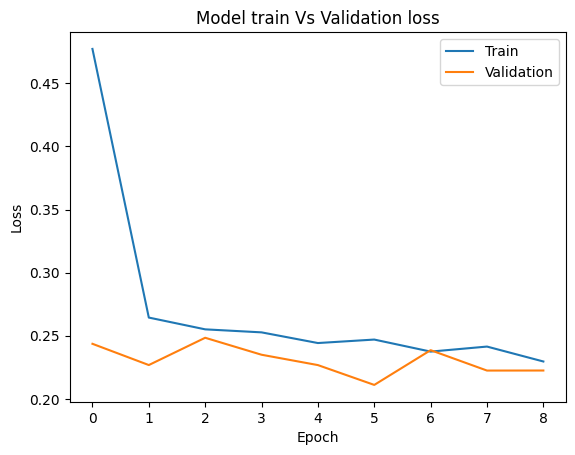

In [ ]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model train Vs Validation loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()

In [ ]:
#print(predictions.max())
#print(predictions.min())

2.6328354
-2.8867517


In [ ]:
#Y_test_original = scalery.inverse_transform(Y_test)
#predictions_original = scalery.inverse_transform(predictions)

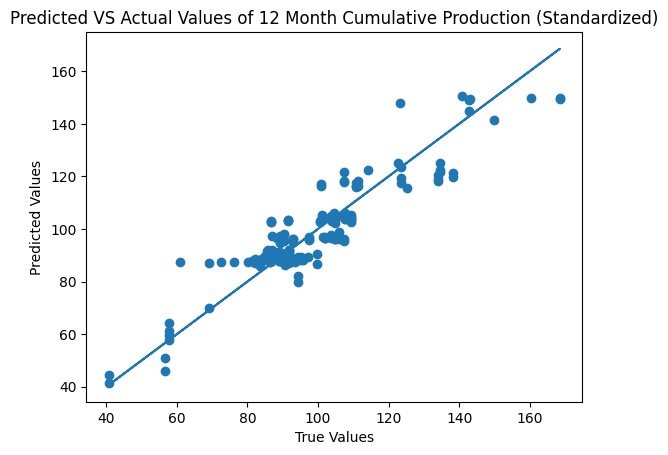

In [ ]:
#plt.scatter(Y_test_original, predictions_original)
#plt.plot(Y_test_original, Y_test_original)
#plt.xlabel('True Values')
#plt.ylabel('Predicted Values')
#plt.title('Predicted VS Actual Values of 12 Month Cumulative Production (Standardized)')
#plt.show()

In [ ]:
# Mean Squared Error (MSE)
#mse = mean_squared_error(Y_test_original, predictions_original)
#print("Mean Squared Error: {:.2f}".format(mse))

# Root Mean Squared Error (RMSE)
#rmse = np.sqrt(mse)
#print("Root Mean Squared Error: {:.2f}".format(rmse))

# Mean Absolute Error (MAE)
#mae = mean_absolute_error(Y_test_original, predictions_original)
#print("Mean Absolute Error: {:.2f}".format(mae))

# R2 Score (Coefficient of Determination)
#r2 = r2_score(Y_test_original, predictions_original)
#print("R2 Score: {:.2f}".format(r2))

Mean Squared Error: 53.98
Root Mean Squared Error: 7.35
Mean Absolute Error: 5.59
R2 Score: 0.84


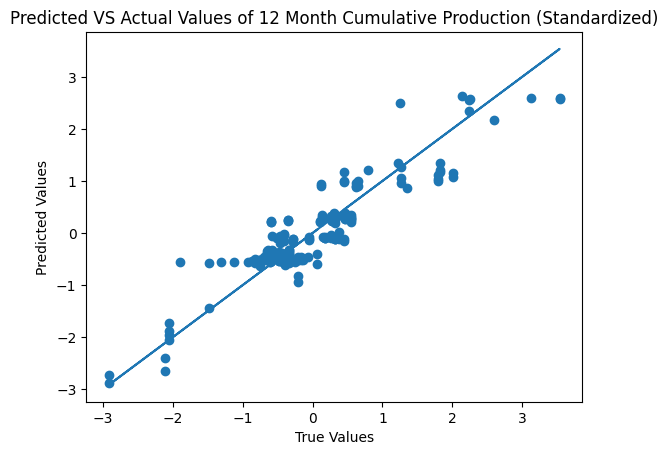

In [ ]:
plt.scatter(Y_test, predictions)
plt.plot(Y_test, Y_test)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted VS Actual Values of 12 Month Cumulative Production (Standardized)')
plt.show()


In [ ]:
# Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, predictions)
print("Mean Squared Error: {:.2f}".format(mse))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, predictions)
print("Mean Absolute Error: {:.2f}".format(mae))

# R2 Score (Coefficient of Determination)
r2 = r2_score(Y_test, predictions)
print("R2 Score: {:.2f}".format(r2))

Mean Squared Error: 0.14
Root Mean Squared Error: 0.37
Mean Absolute Error: 0.28
R2 Score: 0.84


# 500 Realization Plot

In [16]:
Realization500 = pd.read_csv(f"{data_location}/lstm_500.csv", index_col=0)

In [17]:
Realization500

,MSE,MSEoriginal500
0,77.561278,0.197683
1,75.940982,0.193554
2,77.147959,0.196630
3,82.368116,0.209935
4,76.993541,0.196236
...,...,...
496,0.217488,85.331714
497,0.146987,57.670666
498,0.147023,57.684719
499,0.148851,58.401972


In [20]:
MSE500 = []
MSEoriginal500 = []

In [21]:
for index, row in Realization500.iterrows():
  if row['MSE'] < 10:
    MSE500.append(row['MSE'])
  else:
    MSEoriginal500.append(row['MSE'])
  if row['MSEoriginal500'] > 10:
    MSEoriginal500.append(row['MSEoriginal500'])
  else:
    MSE500.append(row['MSEoriginal500'])

In [24]:
pd.DataFrame({"MSE":MSE500, "MSEoriginal":MSEoriginal500}).to_csv(f"{data_location}/lstm_500.csv")

In [25]:
Realization500 = pd.read_csv(f"{data_location}/lstm_500.csv", index_col=0)

In [26]:
Realization500

,MSE,MSEoriginal
0,0.197683,77.561278
1,0.193554,75.940982
2,0.196630,77.147959
3,0.209935,82.368116
4,0.196236,76.993541
...,...,...
496,0.217488,85.331714
497,0.146987,57.670666
498,0.147023,57.684719
499,0.148851,58.401972


In [30]:
rmse500 = np.sqrt(Realization500['MSEoriginal'])
ci500 = np.percentile(rmse500, [2.5, 97.5])

In [35]:
ci500

array([ 7.36938003, 10.08610867])

In [31]:
rmse100 = np.sqrt(Realization500['MSEoriginal'][:100])
ci100 = np.percentile(rmse100, [2.5, 97.5])

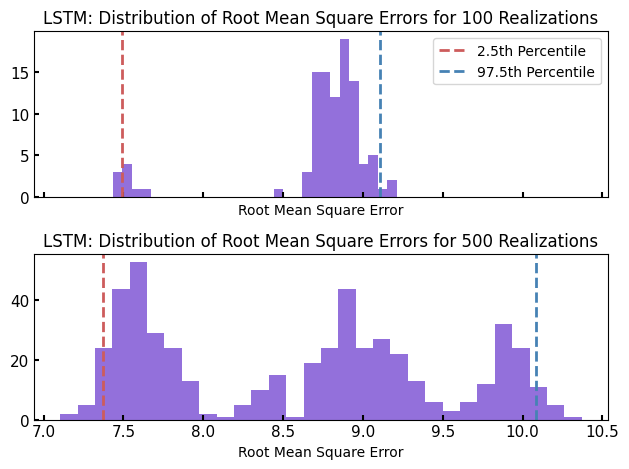

In [34]:
n_bins = 30
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)

axs[0].hist(rmse100, color="mediumpurple", bins=n_bins)
axs[0].axvline(ci100[0], color='indianred', linewidth=2, linestyle = '--', label="2.5th Percentile")
axs[0].axvline(ci100[1], color='steelblue', linewidth=2, linestyle = '--', label="97.5th Percentile")

axs[0].set_xlabel('Root Mean Square Error')
axs[0].set_title('LSTM: Distribution of Root Mean Square Errors for 100 Realizations')
axs[0].legend()
axs[0].tick_params(axis='both', which='both', width=1.5, labelsize=11, direction='in')


axs[1].hist(rmse500, color="mediumpurple", bins=n_bins)
axs[1].axvline(ci500[0], color='indianred', linewidth=2, linestyle = '--', label="2.5th Percentile")
axs[1].axvline(ci500[1], color='steelblue', linewidth=2, linestyle = '--', label="97.5th Percentile")

axs[1].set_xlabel('Root Mean Square Error')
axs[1].set_title('LSTM: Distribution of Root Mean Square Errors for 500 Realizations')

axs[1].tick_params(axis='both', which='both', width=1.5, labelsize=11, direction='in')
#axs[1].grid()
plt.show()